In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.optimize import curve_fit
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import resample
from sklearn.linear_model import Lasso

## Lasso Linear Regression with L1 regularization

In [2]:
walkable_cities = pd.read_csv("walkable-cities.csv")
#uses the loc method to select the subset of rows and columns where the column names are not duplicated. 
walkable_cities = walkable_cities.loc[:,~walkable_cities.columns.duplicated()]
#removes the specified columns from the walkable_cities dataframe
walkable_cities.drop(walkable_cities.columns[[4,5,6,7,11]], axis=1, inplace=True)
walkable_cities

,place_code,city,state,pop_estimate_2021,geo_code,land_area_sqkm,pop_per_km2,median_age,male,female,...,mean_household_income,mean_income,median_household_income,living_wage,poverty,unemployment_rate,median_aqi,violent_crime,property_crime,walkable
0,3076,Auburn,Alabama,78564,103076.0,157.084761,500.137630,27.8,0.483186,0.516662,...,79325.0,29770.0,48531.0,32556.0,0.231926,NaN,NaN,NaN,NaN,car dependent
1,7000,Birmingham,Alabama,197575,107000.0,380.801025,518.840515,37.2,0.479291,0.514812,...,58012.0,27211.0,36614.0,36193.0,0.270712,7.4,51.0,NaN,NaN,car dependent
2,20104,Decatur,Alabama,57804,120104.0,140.785624,410.581694,NaN,NaN,NaN,...,NaN,NaN,NaN,31259.0,NaN,NaN,39.0,NaN,NaN,car dependent
3,21184,Dothan,Alabama,71175,121184.0,232.650562,305.930918,40.5,0.473565,0.527952,...,70513.0,31168.0,45088.0,31803.0,0.209933,5.3,NaN,NaN,NaN,car dependent
4,35896,Hoover,Alabama,92589,135896.0,124.490626,743.742746,38.9,0.504066,0.495923,...,124562.0,50046.0,99276.0,36193.0,0.059813,3.5,51.0,0.001231,0.020758,car dependent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,66000,Racine,Wisconsin,77127,5566000.0,40.080067,1924.323130,34.6,0.476954,0.523098,...,60267.0,24591.0,47861.0,33541.0,0.221427,6.4,43.0,0.003773,0.012836,walkable
756,84250,Waukesha,Wisconsin,71256,5584250.0,66.102904,1077.955667,36.2,0.482654,0.517318,...,88781.0,38381.0,69533.0,34586.0,0.077860,NaN,43.0,0.000940,0.009683,car dependent
757,85300,West Allis,Wisconsin,59484,5585300.0,29.477371,2017.954722,NaN,NaN,NaN,...,NaN,NaN,NaN,34586.0,NaN,NaN,45.0,0.003547,0.028344,walkable
758,13150,Casper,Wyoming,58656,5613150.0,68.757037,853.090863,NaN,NaN,NaN,...,NaN,NaN,NaN,30785.0,NaN,NaN,42.0,0.002881,0.028590,car dependent


In [3]:
data = walkable_cities[['pop_estimate_2021',
       'land_area_sqkm', 'pop_per_km2', 'median_age', 'male', 'female',
       'white_alone', 'black_or_african_american_alone',
       'american_indian_and_alaska_native_alone', 'asian_alone',
       'native_hawaiian_and_other_pacific_islander_alone',
       'some_other_race_alone', 'two_or_more_races', 'hispanic_or_latino',
       'access2', 'arthritis', 'binge', 'bphigh', 'bpmed', 'cancer', 'casthma',
       'cervical', 'chd', 'checkup', 'cholscreen', 'colon_screen', 'copd',
       'corem', 'corew', 'csmoking', 'dental', 'depression', 'diabetes',
       'ghlth', 'highchol', 'kidney', 'lpa', 'mammouse', 'mhlth', 'obesity',
       'phlth', 'sleep', 'stroke', 'teethlost', 'cumulative_confirmed',
       'cumulative_deceased', 'walk_score', 'bike_score', 'drive_commute',
       'public_transit_commute', 'walk_commute', 'bike_commute',
       'work_from_home', 'households', 'mean_household_income', 'mean_income',
       'median_household_income', 'living_wage', 'poverty',
       'unemployment_rate', 'median_aqi', 'violent_crime', 'property_crime']]

data.head()

,pop_estimate_2021,land_area_sqkm,pop_per_km2,median_age,male,female,white_alone,black_or_african_american_alone,american_indian_and_alaska_native_alone,asian_alone,...,households,mean_household_income,mean_income,median_household_income,living_wage,poverty,unemployment_rate,median_aqi,violent_crime,property_crime
0,78564,157.084761,500.137630,27.8,0.483186,0.516662,0.622652,0.178313,0.003029,0.094369,...,0.370857,79325.0,29770.0,48531.0,32556.0,0.231926,NaN,NaN,NaN,NaN
1,197575,380.801025,518.840515,37.2,0.479291,0.514812,0.238942,0.694906,0.003821,0.016576,...,0.443224,58012.0,27211.0,36614.0,36193.0,0.270712,7.4,51.0,NaN,NaN
2,57804,140.785624,410.581694,NaN,NaN,NaN,0.574182,0.232527,0.007491,0.009186,...,NaN,NaN,NaN,NaN,31259.0,NaN,NaN,39.0,NaN,NaN
3,71175,232.650562,305.930918,40.5,0.473565,0.527952,0.568964,0.335736,0.004004,0.016031,...,0.425725,70513.0,31168.0,45088.0,31803.0,0.209933,5.3,NaN,NaN,NaN
4,92589,124.490626,743.742746,38.9,0.504066,0.495923,0.687598,0.168713,0.002743,0.064036,...,0.396602,124562.0,50046.0,99276.0,36193.0,0.059813,3.5,51.0,0.001231,0.020758


In [4]:
data.describe()

,pop_estimate_2021,land_area_sqkm,pop_per_km2,median_age,male,female,white_alone,black_or_african_american_alone,american_indian_and_alaska_native_alone,asian_alone,...,households,mean_household_income,mean_income,median_household_income,living_wage,poverty,unemployment_rate,median_aqi,violent_crime,property_crime
count,7.600000e+02,756.000000,756.000000,564.000000,564.000000,564.000000,755.000000,755.000000,755.000000,755.000000,...,563.000000,563.000000,564.000000,564.000000,727.000000,564.000000,518.000000,681.000000,633.000000,633.000000
mean,1.646429e+05,135.344888,1589.308126,36.554787,0.492196,0.508244,0.530158,0.136474,0.010493,0.082841,...,0.382859,97922.424512,37995.865248,73858.675532,38843.456671,0.135641,6.892085,47.157122,0.004210,0.025443
std,3.924743e+05,186.608511,1505.860211,4.354124,0.018344,0.017905,0.195627,0.153452,0.010476,0.107579,...,0.049541,33448.610008,13202.716289,26481.199768,6538.581192,0.061697,2.587433,17.362578,0.003196,0.012229
min,5.010400e+04,3.238030,93.047234,22.800000,0.427906,0.342966,0.025274,0.002961,0.001181,0.001917,...,0.245462,49626.000000,17236.000000,32217.000000,29353.000000,0.017209,1.300000,15.000000,0.000298,0.005378
25%,6.490600e+04,49.981347,797.451711,33.900000,0.480277,0.497261,0.398436,0.030277,0.004162,0.023772,...,0.352608,75498.000000,28768.500000,55021.250000,34211.500000,0.087817,5.100000,38.000000,0.001950,0.016792
50%,8.838150e+04,83.929773,1179.498942,36.550000,0.492517,0.508403,0.535662,0.076221,0.007370,0.044357,...,0.388017,89800.000000,35076.000000,67973.500000,37075.000000,0.129836,6.700000,42.000000,0.003531,0.023194
75%,1.378420e+05,142.740369,1820.268367,39.000000,0.503238,0.519734,0.689173,0.188963,0.013254,0.092825,...,0.417305,112246.500000,43269.250000,86506.000000,42241.000000,0.173281,8.300000,49.000000,0.005670,0.032411
max,8.467513e+06,1935.461994,19691.366525,51.000000,0.657102,0.571949,0.877240,0.912617,0.129305,0.727708,...,0.516764,268748.000000,102537.000000,205219.000000,64090.000000,0.421409,17.400000,122.000000,0.020618,0.086487


### Scaling:
 The data is scaled using the StandardScaler() function. This function normalizes the data by subtracting the mean and dividing by the standard deviation. This is done to ensure that all features are on the same scale.

In [5]:
"""
# Scaling - normalize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Create an imputer object with strategy='mean' or 'median'
imputer = SimpleImputer(strategy='mean')

# Fit and transform the data using the imputer
data_scaled = imputer.fit_transform(data_scaled)
"""

"\n# Scaling - normalize the data\nscaler = StandardScaler()\ndata_scaled = scaler.fit_transform(data)\n\n# Create an imputer object with strategy='mean' or 'median'\nimputer = SimpleImputer(strategy='mean')\n\n# Fit and transform the data using the imputer\ndata_scaled = imputer.fit_transform(data_scaled)\n"

### Bootstrap sample of the data_scaled dataset. 

The n_samples parameter is set to 2000, which means that the bootstrap sample will have 2000 rows. The replace parameter is set to True, which means that the same data point can be sampled multiple times. The random_state parameter is set to 42, which ensures that the sample is reproducible.

In [6]:
# Bootstrap the data_scaled to create 2000 rows
bootstrap = resample(data, n_samples=2000, replace=True, random_state=42) # for using scale method, change the name "data" for "data_scaled"

# Convert the bootstrap sample to a dataframe
df = pd.DataFrame(bootstrap, columns=data.columns)

# Display the bootstrapped dataframe
print('Bootstrapped data:')
print(df)

Bootstrapped data:
     pop_estimate_2021  land_area_sqkm  pop_per_km2  median_age      male  \
102             106941      111.216608   961.556029        32.9  0.504493   
435             112684      101.381374  1111.486218        34.5  0.477273   
270              82341       48.007290  1715.177007        46.3  0.482129   
106              85742       43.288926  1980.691320        42.1  0.499778   
71              111645       32.138031  3473.921598        40.3  0.492346   
..                 ...             ...          ...         ...       ...   
525             210606       92.634700  2273.510898        34.6  0.477147   
333              59459       36.876383  1612.386985         NaN       NaN   
1               197575      380.801025   518.840515        37.2  0.479291   
374              85617      151.411679   565.458362        37.0  0.517958   
292              62043       65.916407   941.237589         NaN       NaN   

       female  white_alone  black_or_african_american_al

In [7]:
df.describe()

,pop_estimate_2021,land_area_sqkm,pop_per_km2,median_age,male,female,white_alone,black_or_african_american_alone,american_indian_and_alaska_native_alone,asian_alone,...,households,mean_household_income,mean_income,median_household_income,living_wage,poverty,unemployment_rate,median_aqi,violent_crime,property_crime
count,2.000000e+03,1990.000000,1990.000000,1487.000000,1487.000000,1487.000000,1986.000000,1986.000000,1986.000000,1986.000000,...,1486.000000,1486.000000,1487.000000,1487.000000,1912.000000,1487.000000,1367.000000,1797.000000,1674.000000,1674.000000
mean,1.715765e+05,139.845023,1600.832028,36.517283,0.492247,0.508159,0.532226,0.135549,0.010745,0.081887,...,0.382213,99557.551144,38525.863484,74904.199731,38912.589435,0.135629,6.734016,47.095715,0.004153,0.025205
std,4.815398e+05,199.111469,1629.521537,4.564221,0.017529,0.017147,0.190657,0.151900,0.011273,0.102219,...,0.049111,35533.816571,13908.735165,27856.086248,6526.395554,0.061864,2.587334,17.856511,0.003140,0.011755
min,5.010400e+04,3.238030,93.047234,22.800000,0.427906,0.342966,0.025274,0.002961,0.001181,0.001917,...,0.245462,49626.000000,17236.000000,32217.000000,29818.000000,0.017209,1.300000,15.000000,0.000298,0.005378
25%,6.503500e+04,50.093079,758.141337,33.750000,0.480445,0.496990,0.406675,0.030024,0.004226,0.023848,...,0.351569,75771.000000,28961.500000,55446.000000,34196.000000,0.088501,4.900000,38.000000,0.001928,0.016784
50%,8.911400e+04,82.459214,1169.727289,36.600000,0.492654,0.507643,0.536620,0.077518,0.007343,0.044246,...,0.387473,90551.000000,35073.000000,67950.000000,37075.000000,0.129226,6.300000,42.000000,0.003506,0.023521
75%,1.373332e+05,144.588058,1794.523637,38.900000,0.503282,0.519493,0.685437,0.181869,0.013384,0.095525,...,0.417270,112874.000000,44504.000000,88815.000000,42255.250000,0.171863,8.200000,49.000000,0.005453,0.032339
max,8.467513e+06,1935.461994,19691.366525,51.000000,0.657102,0.571949,0.877240,0.912617,0.129305,0.727708,...,0.516764,268748.000000,102537.000000,205219.000000,64090.000000,0.421409,17.400000,122.000000,0.020618,0.077703


### Interpolate method from pandas

The method set to "nearest" and the xis parameter set to 0. The inplace parameter is set to True, which means that the interpolation is done on the original dataframe.

In [8]:
# Do the original interpolation
df.interpolate(method='nearest', xis=0, inplace=True)

# Display result
print ('Interpolated data:')
print (df)
print ()

Interpolated data:
     pop_estimate_2021  land_area_sqkm  pop_per_km2  median_age      male  \
102             106941      111.216608   961.556029        32.9  0.504493   
435             112684      101.381374  1111.486218        34.5  0.477273   
270              82341       48.007290  1715.177007        46.3  0.482129   
106              85742       43.288926  1980.691320        42.1  0.499778   
71              111645       32.138031  3473.921598        40.3  0.492346   
..                 ...             ...          ...         ...       ...   
525             210606       92.634700  2273.510898        34.6  0.477147   
333              59459       36.876383  1612.386985        36.8  0.527263   
1               197575      380.801025   518.840515        37.2  0.479291   
374              85617      151.411679   565.458362        37.0  0.517958   
292              62043       65.916407   941.237589        43.1  0.497253   

       female  white_alone  black_or_african_american_al

This function takes in a variable "x" and an arbitrary number of parameters represented by the *params argument. The function then creates a variable "y" that is initialized to 0. A loop is then used to iterate through the parameters and add the product of each parameter and the corresponding power of x to the "y" variable. The function returns "y" at the end.

In [9]:
# Function to curve fit to the data
def func(x, *params):
    y = 0
    for i in range(len(params)):
        y += params[i] * (x ** i)
    return y

### Fitting process

A variable called "guess" is then defined, which is a list of 1's with a length equal to the number of columns in the dataframe. This is used as an initial parameter guess for the curve fitting process.

In [10]:
# Initial parameter guess, just to kick off the optimization
guess = [1] * len(df.columns)

# Create copy of df to remove NaNs for curve fitting
fit_data = df.dropna()

# Place to store function parameters for each column
col_params = {}

# Curve fit each column
for col in fit_data.columns:
    # Get x & y
    x = fit_data.index.astype(float).values
    y = fit_data[col].values
    # Curve fit column and get curve parameters
    params = curve_fit(func, x, y, guess)
    # Store optimized parameters
    col_params[col] = params[0]

<ipython-input-9-672060720b92>:5: RuntimeWarning: overflow encountered in multiply
  y += params[i] * (x ** i)
<ipython-input-9-672060720b92>:5: RuntimeWarning: invalid value encountered in add
  y += params[i] * (x ** i)
<ipython-input-9-672060720b92>:5: RuntimeWarning: overflow encountered in add
  y += params[i] * (x ** i)


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 102 to 292
Data columns (total 63 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   pop_estimate_2021                                 2000 non-null   int64  
 1   land_area_sqkm                                    2000 non-null   float64
 2   pop_per_km2                                       2000 non-null   float64
 3   median_age                                        1991 non-null   float64
 4   male                                              1991 non-null   float64
 5   female                                            1991 non-null   float64
 6   white_alone                                       2000 non-null   float64
 7   black_or_african_american_alone                   2000 non-null   float64
 8   american_indian_and_alaska_native_alone           2000 non-null   float64
 9   asian_alone       

### Extrapolate

In [12]:
# Extrapolate each column
for col in df.columns:
    # Get the index values for NaNs in the column
    x = df[pd.isnull(df[col])].index.astype(float).values
    # Iterate through each index value and set the value to the extrapolated result
    for idx in x:
        df.loc[idx, col] = func(idx, *col_params[col])

# Display result
print ('Extrapolated df:')
print (df)
print ()

print ('df was extrapolated with these column functions:')

Extrapolated df:
     pop_estimate_2021  land_area_sqkm  pop_per_km2  median_age      male  \
102             106941      111.216608   961.556029        32.9  0.504493   
435             112684      101.381374  1111.486218        34.5  0.477273   
270              82341       48.007290  1715.177007        46.3  0.482129   
106              85742       43.288926  1980.691320        42.1  0.499778   
71              111645       32.138031  3473.921598        40.3  0.492346   
..                 ...             ...          ...         ...       ...   
525             210606       92.634700  2273.510898        34.6  0.477147   
333              59459       36.876383  1612.386985        36.8  0.527263   
1               197575      380.801025   518.840515        37.2  0.479291   
374              85617      151.411679   565.458362        37.0  0.517958   
292              62043       65.916407   941.237589        43.1  0.497253   

       female  white_alone  black_or_african_american_alon

<ipython-input-9-672060720b92>:5: RuntimeWarning: overflow encountered in double_scalars
  y += params[i] * (x ** i)
<ipython-input-9-672060720b92>:5: RuntimeWarning: invalid value encountered in double_scalars
  y += params[i] * (x ** i)


Iterate through the number of parameters in the col_params dictionary and add the corresponding term for each parameter in the string that is being printed.

In [13]:
for col in col_params:
    terms = []
    for i in range(len(col_params[col])):
        terms.append("{:0.3e} x^{}".format(col_params[col][i], i))
    #print("f_{}(x) = {}".format(col, " + ".join(terms)))

In [14]:
# Define the numerical columns
list_numerical = df.columns.drop('walk_score')

# Define the features and target variable
X = df.drop(columns='walk_score')
y = df['walk_score']

# Split the df set into train and test set with the first 70% of the df for training and the remaining 30% for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

X_train

,pop_estimate_2021,land_area_sqkm,pop_per_km2,median_age,male,female,white_alone,black_or_african_american_alone,american_indian_and_alaska_native_alone,asian_alone,...,households,mean_household_income,mean_income,median_household_income,living_wage,poverty,unemployment_rate,median_aqi,violent_crime,property_crime
497,109796,94.371261,1163.447419,39.7,0.517751,0.482176,0.581223,0.029737,0.015957,0.066660,...,0.395206,99038.0,39137.0,78778.0,34316.0,0.070349,7.7,49.0,0.005872,0.023194
215,123436,100.776151,1224.853289,39.7,0.490481,0.512703,0.813661,0.010872,0.010094,0.026005,...,0.410561,113079.0,46680.0,92647.0,42241.0,0.068254,4.5,47.0,0.002155,0.029505
539,298263,335.621779,888.687858,36.3,0.457643,0.542313,0.401354,0.421018,0.005847,0.050854,...,0.415590,75155.0,32208.0,51825.0,34749.0,0.136970,6.4,40.0,0.008181,0.036860
103,64239,38.165702,1683.160446,32.9,0.504493,0.495469,0.697941,0.012671,0.004670,0.099550,...,0.256721,97560.0,26603.0,81052.0,51843.0,0.128089,7.8,49.0,0.000669,0.009449
476,508394,815.061344,623.749370,35.1,0.475771,0.524271,0.552691,0.260855,0.006336,0.031405,...,0.430808,83593.0,36456.0,63396.0,35762.0,0.131215,6.2,45.0,0.013964,0.037616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704,80139,57.468900,1394.475969,34.4,0.458291,0.541746,0.789279,0.009197,0.004205,0.051136,...,0.318222,133229.0,42511.0,104170.0,36578.0,0.040555,2.5,52.0,0.000911,0.014026
551,189347,160.405166,1180.429563,39.5,0.482706,0.517273,0.550524,0.315933,0.002715,0.053304,...,0.448457,54788.0,25307.0,41628.0,32023.0,0.200890,8.2,40.0,0.009411,0.034688
42,407615,387.916575,1050.780055,32.1,0.487646,0.512270,0.385319,0.069441,0.018235,0.077522,...,0.314039,91135.0,29363.0,66666.0,34378.0,0.159413,8.3,84.0,0.004333,0.039434
711,51430,44.908386,1145.220405,36.0,0.478918,0.521082,0.656990,0.082014,0.005775,0.041143,...,0.422379,81788.0,34250.0,57647.0,36578.0,0.104635,5.8,52.0,0.002178,0.017966


### Scaling

This code is performing feature scaling on the training and testing sets using the StandardScaler method from scikit-learn. The StandardScaler method calculates the mean and standard deviation of the features, and then standardizes them by subtracting the mean and dividing by the standard deviation.

In [15]:
# standardize our features. We do this by subtracting the mean from our observations and then dividing the difference by the standard deviation.
scaler = StandardScaler().fit(X_train[list_numerical]) 
X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])

X_train

,pop_estimate_2021,land_area_sqkm,pop_per_km2,median_age,male,female,white_alone,black_or_african_american_alone,american_indian_and_alaska_native_alone,asian_alone,...,households,mean_household_income,mean_income,median_household_income,living_wage,poverty,unemployment_rate,median_aqi,violent_crime,property_crime
497,-0.119352,-0.227867,-0.248988,0.705752,1.461398,-1.499709,0.229058,-0.691685,0.481593,-0.151414,...,0.243983,0.031887,0.090428,0.180581,-0.709977,-1.101439,0.414507,0.162972,0.564662,-0.204694
215,-0.092049,-0.196709,-0.213524,0.705752,-0.126277,0.285364,1.460603,-0.818298,-0.050074,-0.550115,...,0.557045,0.443377,0.658057,0.700549,0.521741,-1.137105,-0.861517,0.043897,-0.619953,0.305470
539,0.257904,0.945771,-0.407670,-0.060544,-2.038100,2.016842,-0.723964,1.934425,-0.435238,-0.306419,...,0.659569,-0.668038,-0.430997,-0.829925,-0.642680,0.032922,-0.103878,-0.372866,1.300409,0.899985
103,-0.210544,-0.501297,0.051162,-0.826840,0.689517,-0.722370,0.847472,-0.806222,-0.541990,0.171141,...,-2.579434,-0.011428,-0.852787,0.265836,2.014101,-0.118285,0.454383,0.162972,-1.093400,-1.315709
476,0.678526,3.278155,-0.560680,-0.331001,-0.982704,0.961784,0.077884,0.859480,-0.390941,-0.497163,...,0.969833,-0.420750,-0.111324,-0.396112,-0.485237,-0.065061,-0.183629,-0.075178,3.143374,0.961128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704,-0.178717,-0.407390,-0.115562,-0.488768,-2.000365,1.983680,1.331418,-0.829544,-0.584148,-0.303657,...,-1.325553,1.033901,0.344329,1.132562,-0.358413,-1.608745,-1.659032,0.341584,-1.016422,-0.945776
551,0.039886,0.093375,-0.239180,0.660676,-0.578913,0.552572,0.066398,1.229143,-0.719328,-0.282394,...,1.329669,-1.264920,-0.950314,-1.212225,-1.066360,1.121304,0.613886,-0.372866,1.692591,0.724381
42,0.476795,1.200176,-0.314057,-1.007145,-0.291300,0.260056,-0.808920,-0.425212,0.688225,-0.044893,...,-1.410838,-0.199722,-0.645090,-0.273515,-0.700341,0.415060,0.653762,2.246782,0.074020,1.108063
711,-0.236184,-0.468495,-0.259515,-0.128158,-0.799487,0.775349,0.630500,-0.340821,-0.441799,-0.401657,...,0.797988,-0.473648,-0.277331,-0.611650,-0.358413,-0.517650,-0.343132,0.341584,-0.612701,-0.627254


### Lasso Linear Regression with L1 regularization, using the X_train and y_train data.

In [16]:

# Create an imputer with mean strategy, which will replace any missing values in the data with the mean value of the column.
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on the training set
X_train = imputer.fit_transform(X_train)

# Transform the test set
X_test = imputer.transform(X_test)

# Fit and train the Lasso model on the training data with alpha=1
reg = Lasso(alpha=1)
reg.fit(X_train, y_train)

# Print the R squared for the training and test sets

print('R squared training set', round(reg.score(X_train, y_train)*100, 2))
print('R squared test set', round(reg.score(X_test, y_test)*100, 2))

R squared training set 74.82
R squared test set 74.36


### Calculate the mean squared error for the training and test sets

The code is calculating the mean squared error (MSE) for both the training and test sets. MSE is a measure of how well the model is able to predict the target variable (in this case, 'walk_score') based on the features. A lower MSE indicates a better fit of the model to the data.

In [17]:
# Training data

pred_train = reg.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set', round(mse_train, 2))

# Test data

pred = reg.predict(X_test)
mse_test =mean_squared_error(y_test, pred)
print('MSE test set', round(mse_test, 2))

MSE training set 67.6
MSE test set 74.24


### Plot the Lasso coefficients as a function of alpha

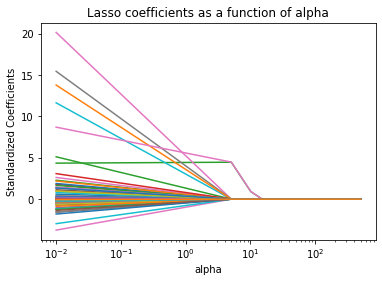

In [18]:

alphas = np.linspace(0.01,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

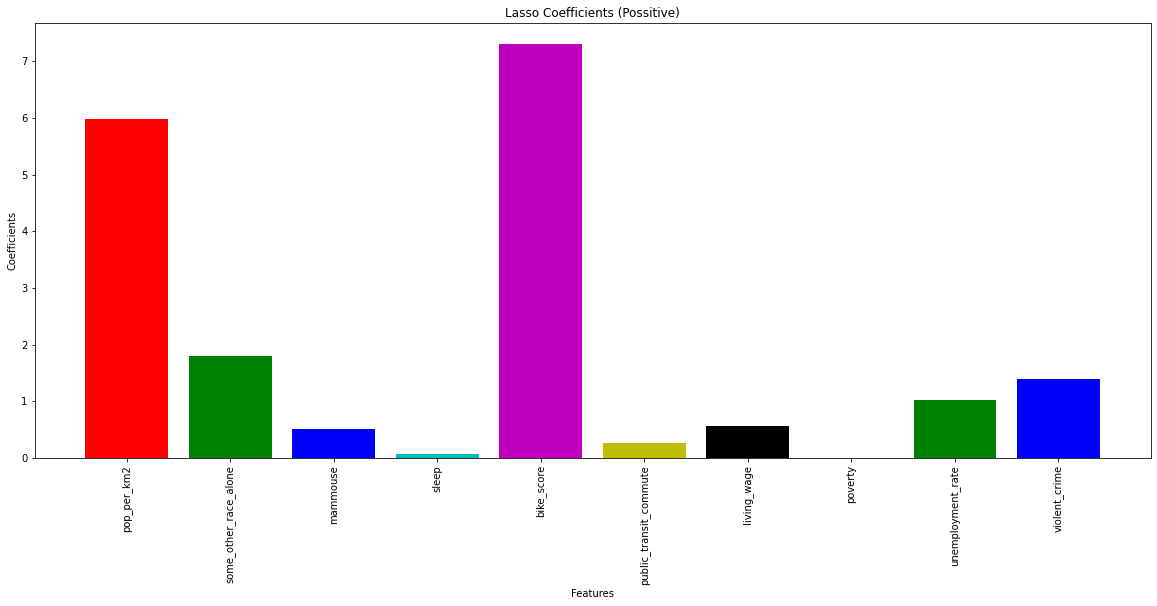

In [19]:
# Create a list of feature importance tuples for only positive coefficients
feature_importance = [(feature, coef) for feature, coef in zip(X.columns, reg.coef_) if coef > 0]

# Extract the features and coefficients into separate lists
features = [f[0] for f in feature_importance]
coefs = [f[1] for f in feature_importance]

# Set the figure size
plt.figure(figsize=(20,8))

# Create a bar plot of the feature importance with different colors for each feature
plt.bar(features, coefs, color=['r','g','b','c','m','y','k'])
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.title("Lasso Coefficients (Possitive)")
plt.xticks(rotation=90)
plt.show()